In [1]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import random as rn 

In [2]:
seed_num =42
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
n_hours = 3
n_features = 43
train_num_24 = 2789
train_num_25 = 2892
train_num_19 = 1934

In [5]:
from os.path import join
df = pd.read_excel('rain_data.xlsx')
df.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,데이터 집단 6,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [6]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()
df_matrix = df_matrix[0:train_num_25, 5:]
print(df_matrix)

df_matrix = df_matrix.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
df_matrix = scaler.fit_transform(df_matrix)

df_matrix

[[189.1         6.4         7.        ...   8.          2.54
  122.61     ]
 [216.9519618   6.3         7.        ...  10.          2.53
  122.6      ]
 [251.4244187   6.4         7.        ...  11.          2.53
  122.59     ]
 ...
 [481.1030831   3.3854      1.        ...   1.          2.96
  137.165    ]
 [470.4581089   3.2841      1.        ...   1.          2.94
  137.18     ]
 [        nan  14.2576     32.        ...   0.          1.93
  120.515    ]]


array([[0.0086303 , 0.01948843, 0.0212766 , ..., 0.03065134, 0.09392971,
        0.15531301],
       [0.00992569, 0.01918392, 0.0212766 , ..., 0.03831417, 0.09329073,
        0.15491581],
       [0.01152899, 0.01948843, 0.0212766 , ..., 0.04214559, 0.09329073,
        0.1545186 ],
       ...,
       [0.02221129, 0.01030877, 0.00303951, ..., 0.00383142, 0.12076677,
        0.7334657 ],
       [0.0217162 , 0.0100003 , 0.00303951, ..., 0.00383142, 0.11948882,
        0.73406124],
       [       nan, 0.04341535, 0.09726444, ..., 0.        , 0.05495208,
        0.07209539]], dtype=float32)

In [7]:
# print(df_matrix)
lag = series_to_supervised(df_matrix, n_hours,1)

lag = lag.values

tmp = lag.shape[1]-42

lag = lag[:,0:tmp]
print(lag.shape)
print(lag)

(2888, 130)
[[0.0086303  0.01948843 0.0212766  ... 0.09329073 0.1545186  0.01391903]
 [0.00992569 0.01918392 0.0212766  ... 0.09329073 0.15431976 0.01773149]
 [0.01152899 0.01948843 0.0212766  ... 0.09329073 0.15392256 0.02367161]
 ...
 [0.02415942 0.11118423 0.03039514 ... 0.1233227  0.73267174 0.022716  ]
 [0.02371195 0.06937759 0.01823708 ... 0.12204473 0.73306847 0.02221129]
 [0.02322259 0.02514799 0.00607903 ... 0.12076677 0.7334657  0.0217162 ]]


In [8]:
n_train_hours = train_num_19
train = lag[:n_train_hours, :]
test = lag[n_train_hours:, :]

In [9]:
##1
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1934, 129) 1934 (1934,)
(1934, 3, 43) (1934,) (954, 3, 43) (954,)


In [10]:
# #testing
# model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))

# model.add(Dense(1))

In [11]:
# testing
model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))
model.add(LSTM(20, input_shape = (train_X.shape[1],train_X.shape[2]), activation = 'tanh', return_sequences = False))
model.add(Dense(1))

2021-08-27 23:50:10.408491: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-27 23:50:10.426323: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe6e2fc2a50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-27 23:50:10.426341: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [12]:
# # optimizer =tf.train.AdamOptimizer(lea)

# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
adam = tf.keras.optimizers.Adam(lr =0.0001)
model.compile(loss='mse', optimizer='adam')

# history = model.fit(train_X, train_y, 
#                                     epochs=100, 
#                                     batch_size=16,
#                                     validation_data=(test_X, test_y), 
#                                     callbacks=[early_stop, checkpoint])
history = model.fit(train_X, train_y, 
                                    epochs=5000, 
                                    batch_size=32,
                                    validation_data=(test_X, test_y))

pred = model.predict(test_X)

Epoch 1/5000
61/61 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0011
Epoch 2/5000
61/61 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 7.4757e-04
Epoch 3/5000
61/61 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.3957e-04
Epoch 4/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.8546e-04 - val_loss: 4.6788e-04
Epoch 5/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8726e-04 - val_loss: 3.9546e-04
Epoch 6/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.7299e-04 - val_loss: 3.7971e-04
Epoch 7/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0011e-04 - val_loss: 3.6331e-04
Epoch 8/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3477e-04 - val_loss: 3.0952e-04
Epoch 9/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7343e-04 - val_loss: 2.9860e-04
Epoch 10/5000
61/61 [======================

61/61 [==============================] - 0s 4ms/step - loss: 2.8626e-05 - val_loss: 2.5384e-05
Epoch 77/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6060e-05 - val_loss: 2.5877e-05
Epoch 78/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9841e-05 - val_loss: 2.3129e-05
Epoch 79/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.0714e-05 - val_loss: 2.8301e-05
Epoch 80/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1847e-05 - val_loss: 1.8026e-05
Epoch 81/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6419e-05 - val_loss: 3.4604e-05
Epoch 82/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0005e-05 - val_loss: 2.3984e-05
Epoch 83/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.7961e-05 - val_loss: 2.0938e-05
Epoch 84/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7790e-05 - val_loss: 2.6150e-05
Epoch 85/5000
61/61 [============

Epoch 151/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.8443e-06 - val_loss: 1.0440e-05
Epoch 152/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.4093e-06 - val_loss: 1.8410e-05
Epoch 153/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2090e-05 - val_loss: 9.9988e-06
Epoch 154/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0356e-05 - val_loss: 8.9709e-06
Epoch 155/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1215e-05 - val_loss: 2.1604e-05
Epoch 156/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.6315e-06 - val_loss: 1.3136e-05
Epoch 157/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.1043e-06 - val_loss: 1.4444e-05
Epoch 158/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1350e-05 - val_loss: 1.8921e-05
Epoch 159/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.4080e-05 - val_loss: 5.6982e-05
Epoch 160/

61/61 [==============================] - 0s 3ms/step - loss: 5.2546e-06 - val_loss: 5.9810e-06
Epoch 226/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.2305e-06 - val_loss: 5.5652e-06
Epoch 227/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.6524e-06 - val_loss: 4.7738e-06
Epoch 228/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1439e-05 - val_loss: 7.6378e-06
Epoch 229/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0318e-05 - val_loss: 7.7607e-06
Epoch 230/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0565e-06 - val_loss: 4.9395e-06
Epoch 231/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0406e-06 - val_loss: 7.1343e-06
Epoch 232/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6745e-06 - val_loss: 6.5312e-06
Epoch 233/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.5300e-06 - val_loss: 4.7692e-06
Epoch 234/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 7.5418e-06 - val_loss: 5.1068e-06
Epoch 300/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.7460e-06 - val_loss: 5.5626e-06
Epoch 301/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6178e-06 - val_loss: 4.9456e-06
Epoch 302/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.1940e-06 - val_loss: 4.1548e-06
Epoch 303/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2285e-06 - val_loss: 8.1658e-06
Epoch 304/5000
61/61 [==============================] - 0s 5ms/step - loss: 3.1730e-06 - val_loss: 3.3540e-06
Epoch 305/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.9729e-06 - val_loss: 8.1436e-06
Epoch 306/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.8468e-06 - val_loss: 3.6043e-06
Epoch 307/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8069e-06 - val_loss: 4.0907e-06
Epoch 308/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 2.5387e-06 - val_loss: 4.7898e-06
Epoch 374/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0368e-06 - val_loss: 3.3217e-06
Epoch 375/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8295e-06 - val_loss: 3.1172e-06
Epoch 376/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5568e-06 - val_loss: 2.4616e-06
Epoch 377/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.8586e-06 - val_loss: 8.5055e-06
Epoch 378/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3596e-06 - val_loss: 2.7317e-06
Epoch 379/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6288e-06 - val_loss: 2.7776e-06
Epoch 380/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8524e-06 - val_loss: 2.5899e-06
Epoch 381/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.3843e-06 - val_loss: 8.9712e-06
Epoch 382/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 1.8532e-06 - val_loss: 4.0455e-06
Epoch 448/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8967e-06 - val_loss: 3.6112e-06
Epoch 449/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4038e-06 - val_loss: 2.8639e-06
Epoch 450/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2968e-06 - val_loss: 2.1447e-06
Epoch 451/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6249e-06 - val_loss: 4.7539e-06
Epoch 452/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6203e-06 - val_loss: 3.8446e-06
Epoch 453/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9749e-06 - val_loss: 2.4673e-06
Epoch 454/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5771e-06 - val_loss: 3.5550e-06
Epoch 455/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8861e-06 - val_loss: 2.5472e-06
Epoch 456/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 9.7059e-06 - val_loss: 2.2348e-06
Epoch 522/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2499e-06 - val_loss: 2.3902e-06
Epoch 523/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3107e-06 - val_loss: 2.4638e-06
Epoch 524/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5981e-06 - val_loss: 4.0230e-06
Epoch 525/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9917e-06 - val_loss: 2.3409e-06
Epoch 526/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.1802e-07 - val_loss: 3.0075e-06
Epoch 527/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2562e-06 - val_loss: 1.8325e-06
Epoch 528/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1758e-06 - val_loss: 2.1883e-06
Epoch 529/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0406e-06 - val_loss: 2.5953e-06
Epoch 530/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 2.7300e-06 - val_loss: 3.6095e-06
Epoch 596/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6894e-06 - val_loss: 6.1403e-06
Epoch 597/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0181e-06 - val_loss: 1.7231e-06
Epoch 598/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.4559e-07 - val_loss: 1.9134e-06
Epoch 599/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.5787e-07 - val_loss: 1.9690e-06
Epoch 600/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6349e-06 - val_loss: 2.3985e-06
Epoch 601/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1201e-06 - val_loss: 2.5819e-06
Epoch 602/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8863e-06 - val_loss: 3.2355e-06
Epoch 603/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6353e-06 - val_loss: 1.9887e-06
Epoch 604/5000
61/61 [===

61/61 [==============================] - 0s 4ms/step - loss: 6.8457e-07 - val_loss: 2.3016e-06
Epoch 670/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1275e-06 - val_loss: 2.4933e-06
Epoch 671/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.9798e-07 - val_loss: 2.2718e-06
Epoch 672/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4427e-06 - val_loss: 2.0944e-06
Epoch 673/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9551e-06 - val_loss: 2.6480e-06
Epoch 674/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9557e-06 - val_loss: 8.2392e-06
Epoch 675/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.4692e-06 - val_loss: 3.3496e-06
Epoch 676/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0900e-06 - val_loss: 2.1684e-06
Epoch 677/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.9546e-07 - val_loss: 1.8317e-06
Epoch 678/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 1.7213e-06 - val_loss: 1.8684e-06
Epoch 744/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.6128e-07 - val_loss: 1.6946e-06
Epoch 745/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.2969e-07 - val_loss: 2.2935e-06
Epoch 746/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7349e-06 - val_loss: 2.4205e-06
Epoch 747/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8198e-06 - val_loss: 2.0267e-06
Epoch 748/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8064e-06 - val_loss: 2.3730e-06
Epoch 749/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3567e-06 - val_loss: 3.1876e-06
Epoch 750/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.2404e-06 - val_loss: 2.6545e-06
Epoch 751/5000
61/61 [==============================] - 0s 6ms/step - loss: 1.7912e-06 - val_loss: 2.0836e-06
Epoch 752/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 4.4155e-06 - val_loss: 2.4286e-06
Epoch 818/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6047e-06 - val_loss: 2.6125e-06
Epoch 819/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.5800e-07 - val_loss: 1.8276e-06
Epoch 820/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.2826e-07 - val_loss: 1.9539e-06
Epoch 821/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4358e-06 - val_loss: 1.8583e-06
Epoch 822/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6457e-06 - val_loss: 2.1430e-06
Epoch 823/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0919e-06 - val_loss: 3.8138e-06
Epoch 824/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3381e-06 - val_loss: 3.1445e-06
Epoch 825/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6836e-06 - val_loss: 2.3893e-06
Epoch 826/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 1.2591e-06 - val_loss: 2.6431e-06
Epoch 892/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3197e-06 - val_loss: 1.6096e-06
Epoch 893/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.8199e-07 - val_loss: 3.8828e-06
Epoch 894/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3617e-06 - val_loss: 1.6913e-06
Epoch 895/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.6527e-07 - val_loss: 1.4985e-06
Epoch 896/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8781e-07 - val_loss: 1.6773e-06
Epoch 897/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6374e-07 - val_loss: 2.2156e-06
Epoch 898/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2222e-06 - val_loss: 1.6845e-06
Epoch 899/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1700e-06 - val_loss: 3.5272e-06
Epoch 900/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 6.6866e-07 - val_loss: 1.7572e-06
Epoch 966/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6592e-07 - val_loss: 2.0325e-06
Epoch 967/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9093e-07 - val_loss: 1.6009e-06
Epoch 968/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.3509e-07 - val_loss: 2.0841e-06
Epoch 969/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3269e-07 - val_loss: 1.5290e-06
Epoch 970/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.4321e-07 - val_loss: 1.4626e-06
Epoch 971/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.5557e-07 - val_loss: 1.5702e-06
Epoch 972/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.2234e-07 - val_loss: 5.0253e-06
Epoch 973/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.3459e-07 - val_loss: 1.7701e-06
Epoch 974/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 3.2008e-07 - val_loss: 1.4866e-06
Epoch 1040/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7630e-07 - val_loss: 2.4740e-06
Epoch 1041/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.4993e-07 - val_loss: 1.6899e-06
Epoch 1042/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.7649e-07 - val_loss: 1.5359e-06
Epoch 1043/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0243e-07 - val_loss: 1.3379e-06
Epoch 1044/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2254e-07 - val_loss: 1.7004e-06
Epoch 1045/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.4090e-07 - val_loss: 1.3310e-06
Epoch 1046/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7126e-06 - val_loss: 1.9199e-06
Epoch 1047/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.9709e-07 - val_loss: 1.7502e-06
Epoch 1048/5000
6

Epoch 1113/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2143e-07 - val_loss: 2.0624e-06
Epoch 1114/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1159e-06 - val_loss: 1.6724e-06
Epoch 1115/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.6841e-07 - val_loss: 2.5371e-06
Epoch 1116/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.9439e-07 - val_loss: 1.5358e-06
Epoch 1117/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.5296e-07 - val_loss: 1.5903e-06
Epoch 1118/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7250e-06 - val_loss: 4.3091e-06
Epoch 1119/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6924e-06 - val_loss: 4.3271e-06
Epoch 1120/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.3763e-07 - val_loss: 1.9984e-06
Epoch 1121/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.2745e-07 - val_loss: 1.3997e-06
E

Epoch 1187/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.4448e-07 - val_loss: 1.6917e-06
Epoch 1188/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8964e-07 - val_loss: 1.9318e-06
Epoch 1189/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.5885e-07 - val_loss: 1.4092e-06
Epoch 1190/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.1335e-07 - val_loss: 2.2679e-06
Epoch 1191/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.8776e-07 - val_loss: 2.6160e-06
Epoch 1192/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.4357e-07 - val_loss: 1.3870e-06
Epoch 1193/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0327e-06 - val_loss: 1.6187e-06
Epoch 1194/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9518e-06 - val_loss: 1.8583e-06
Epoch 1195/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0813e-06 - val_loss: 1.7537e-06
E

Epoch 1261/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5225e-07 - val_loss: 1.3241e-06
Epoch 1262/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8295e-07 - val_loss: 2.2462e-06
Epoch 1263/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3133e-06 - val_loss: 3.8014e-06
Epoch 1264/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6812e-06 - val_loss: 1.7441e-06
Epoch 1265/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6122e-07 - val_loss: 1.2772e-06
Epoch 1266/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1326e-07 - val_loss: 1.3469e-06
Epoch 1267/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9731e-07 - val_loss: 1.2735e-06
Epoch 1268/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.6750e-07 - val_loss: 1.5916e-06
Epoch 1269/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.4073e-07 - val_loss: 1.2845e-06
E

Epoch 1335/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.3223e-07 - val_loss: 2.5011e-06
Epoch 1336/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5257e-06 - val_loss: 7.0197e-06
Epoch 1337/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.4407e-06 - val_loss: 2.4472e-06
Epoch 1338/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.2284e-07 - val_loss: 1.3573e-06
Epoch 1339/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8820e-07 - val_loss: 1.5151e-06
Epoch 1340/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2686e-06 - val_loss: 1.7317e-06
Epoch 1341/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6464e-06 - val_loss: 2.8449e-06
Epoch 1342/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2323e-06 - val_loss: 2.4563e-06
Epoch 1343/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.7581e-07 - val_loss: 1.7841e-06
E

Epoch 1409/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5103e-07 - val_loss: 1.7132e-06
Epoch 1410/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3505e-07 - val_loss: 1.1043e-06
Epoch 1411/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8730e-07 - val_loss: 1.0743e-06
Epoch 1412/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.8815e-07 - val_loss: 1.4260e-06
Epoch 1413/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1106e-06 - val_loss: 2.1155e-06
Epoch 1414/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5124e-06 - val_loss: 6.3078e-06
Epoch 1415/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4456e-06 - val_loss: 1.2432e-06
Epoch 1416/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1265e-06 - val_loss: 1.6169e-06
Epoch 1417/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0006e-06 - val_loss: 1.5573e-06
E

Epoch 1483/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.5043e-07 - val_loss: 1.1710e-06
Epoch 1484/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8544e-07 - val_loss: 1.4080e-06
Epoch 1485/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.4118e-07 - val_loss: 1.2536e-06
Epoch 1486/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.0225e-07 - val_loss: 2.5226e-06
Epoch 1487/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1822e-06 - val_loss: 2.4462e-06
Epoch 1488/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.4267e-07 - val_loss: 1.9780e-06
Epoch 1489/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8598e-07 - val_loss: 1.2625e-06
Epoch 1490/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3747e-06 - val_loss: 2.5758e-06
Epoch 1491/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5799e-06 - val_loss: 1.5391e-06
E

Epoch 1557/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.7329e-07 - val_loss: 1.1468e-06
Epoch 1558/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7815e-07 - val_loss: 9.9563e-07
Epoch 1559/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.2815e-07 - val_loss: 1.2959e-06
Epoch 1560/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9283e-06 - val_loss: 1.5830e-06
Epoch 1561/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1832e-07 - val_loss: 1.1071e-06
Epoch 1562/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.3378e-07 - val_loss: 1.1283e-06
Epoch 1563/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2618e-07 - val_loss: 1.2199e-06
Epoch 1564/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1980e-06 - val_loss: 2.3972e-06
Epoch 1565/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3394e-06 - val_loss: 1.2982e-06
E

Epoch 1631/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8812e-07 - val_loss: 1.0772e-06
Epoch 1632/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1753e-07 - val_loss: 1.3848e-06
Epoch 1633/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3712e-07 - val_loss: 1.1527e-06
Epoch 1634/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1815e-07 - val_loss: 1.1436e-06
Epoch 1635/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5495e-07 - val_loss: 1.3119e-06
Epoch 1636/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8397e-07 - val_loss: 1.0608e-06
Epoch 1637/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2226e-07 - val_loss: 9.3229e-07
Epoch 1638/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8092e-07 - val_loss: 1.2672e-06
Epoch 1639/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.8613e-07 - val_loss: 1.1207e-06
E

Epoch 1705/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.6613e-07 - val_loss: 9.2344e-07
Epoch 1706/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3772e-07 - val_loss: 1.1566e-06
Epoch 1707/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5641e-07 - val_loss: 1.0722e-06
Epoch 1708/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.2006e-06 - val_loss: 3.2554e-06
Epoch 1709/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5545e-06 - val_loss: 1.7142e-06
Epoch 1710/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6424e-07 - val_loss: 1.1982e-06
Epoch 1711/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5551e-07 - val_loss: 1.0802e-06
Epoch 1712/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8849e-07 - val_loss: 1.0833e-06
Epoch 1713/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6806e-07 - val_loss: 1.2430e-06
E

Epoch 1779/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.5300e-07 - val_loss: 1.1919e-06
Epoch 1780/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.3722e-07 - val_loss: 1.2259e-06
Epoch 1781/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8887e-07 - val_loss: 1.2357e-06
Epoch 1782/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2713e-07 - val_loss: 1.4391e-06
Epoch 1783/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.4965e-07 - val_loss: 1.8227e-06
Epoch 1784/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1537e-07 - val_loss: 1.2957e-06
Epoch 1785/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.0775e-07 - val_loss: 9.2051e-07
Epoch 1786/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.4054e-07 - val_loss: 1.5758e-06
Epoch 1787/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0731e-06 - val_loss: 2.2617e-06
E

Epoch 1853/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6202e-07 - val_loss: 1.4334e-06
Epoch 1854/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8589e-07 - val_loss: 1.0518e-06
Epoch 1855/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0964e-07 - val_loss: 1.9923e-06
Epoch 1856/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.1727e-07 - val_loss: 9.8745e-07
Epoch 1857/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4423e-06 - val_loss: 1.6237e-06
Epoch 1858/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1020e-06 - val_loss: 1.1765e-06
Epoch 1859/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8789e-07 - val_loss: 9.7131e-07
Epoch 1860/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6869e-07 - val_loss: 8.9669e-07
Epoch 1861/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2409e-07 - val_loss: 1.0780e-06
E

Epoch 1927/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5871e-07 - val_loss: 1.1052e-06
Epoch 1928/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0055e-07 - val_loss: 1.1880e-06
Epoch 1929/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7727e-07 - val_loss: 9.3110e-07
Epoch 1930/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6758e-07 - val_loss: 9.6309e-07
Epoch 1931/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5015e-07 - val_loss: 1.3757e-06
Epoch 1932/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2520e-06 - val_loss: 9.5755e-07
Epoch 1933/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.4465e-07 - val_loss: 9.3778e-07
Epoch 1934/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1565e-07 - val_loss: 1.0561e-06
Epoch 1935/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3022e-07 - val_loss: 9.0836e-07
E

Epoch 2001/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5399e-07 - val_loss: 1.0285e-06
Epoch 2002/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3690e-07 - val_loss: 9.1932e-07
Epoch 2003/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5220e-07 - val_loss: 8.4820e-07
Epoch 2004/5000
61/61 [==============================] - 0s 6ms/step - loss: 2.6724e-07 - val_loss: 9.3906e-07
Epoch 2005/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.4582e-07 - val_loss: 1.4275e-06
Epoch 2006/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.1593e-07 - val_loss: 8.9124e-07
Epoch 2007/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.7880e-07 - val_loss: 1.2123e-06
Epoch 2008/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.6964e-07 - val_loss: 9.0491e-07
Epoch 2009/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.2759e-07 - val_loss: 8.8003e-07
E

Epoch 2075/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3770e-07 - val_loss: 2.8677e-06
Epoch 2076/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0257e-06 - val_loss: 1.8185e-06
Epoch 2077/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2617e-06 - val_loss: 1.6921e-06
Epoch 2078/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.8176e-07 - val_loss: 8.3940e-07
Epoch 2079/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.9936e-07 - val_loss: 1.3455e-06
Epoch 2080/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.4053e-07 - val_loss: 1.0290e-06
Epoch 2081/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.7753e-06 - val_loss: 1.3721e-06
Epoch 2082/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.4569e-06 - val_loss: 9.2142e-06
Epoch 2083/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2917e-06 - val_loss: 1.0384e-06
E

Epoch 2149/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2325e-07 - val_loss: 9.9569e-07
Epoch 2150/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4989e-07 - val_loss: 9.6935e-07
Epoch 2151/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.8447e-08 - val_loss: 9.8846e-07
Epoch 2152/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.1657e-07 - val_loss: 1.0218e-06
Epoch 2153/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.6573e-07 - val_loss: 1.3419e-06
Epoch 2154/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.4055e-07 - val_loss: 1.0500e-06
Epoch 2155/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3592e-07 - val_loss: 9.2265e-07
Epoch 2156/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1198e-07 - val_loss: 2.3673e-06
Epoch 2157/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.4680e-07 - val_loss: 1.3962e-06
E

Epoch 2223/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.7759e-07 - val_loss: 8.2461e-07
Epoch 2224/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.4467e-07 - val_loss: 9.1995e-07
Epoch 2225/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5274e-07 - val_loss: 1.0853e-06
Epoch 2226/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.4255e-06 - val_loss: 3.6561e-06
Epoch 2227/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.1592e-06 - val_loss: 1.1468e-06
Epoch 2228/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.9890e-07 - val_loss: 1.0872e-06
Epoch 2229/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.9434e-07 - val_loss: 1.1958e-06
Epoch 2230/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.0215e-07 - val_loss: 9.3449e-07
Epoch 2231/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0984e-07 - val_loss: 8.1852e-07
E

Epoch 2297/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8383e-07 - val_loss: 1.1666e-06
Epoch 2298/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.1274e-07 - val_loss: 1.0644e-06
Epoch 2299/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8755e-07 - val_loss: 1.0785e-06
Epoch 2300/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.5017e-06 - val_loss: 1.8803e-06
Epoch 2301/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0000e-06 - val_loss: 1.2308e-06
Epoch 2302/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.6051e-07 - val_loss: 1.3582e-06
Epoch 2303/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.5172e-07 - val_loss: 1.6221e-06
Epoch 2304/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0403e-06 - val_loss: 1.7579e-06
Epoch 2305/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.9441e-07 - val_loss: 9.7819e-07
E

Epoch 2371/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.0661e-06 - val_loss: 5.5223e-06
Epoch 2372/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.6557e-06 - val_loss: 1.0915e-06
Epoch 2373/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.8887e-07 - val_loss: 1.0292e-06
Epoch 2374/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.8655e-07 - val_loss: 9.5065e-07
Epoch 2375/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.6004e-07 - val_loss: 8.3436e-07
Epoch 2376/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.9306e-08 - val_loss: 8.9910e-07
Epoch 2377/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4309e-07 - val_loss: 8.3907e-07
Epoch 2378/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.4709e-07 - val_loss: 8.0743e-07
Epoch 2379/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.7433e-07 - val_loss: 8.1475e-07
E

Epoch 2445/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.5560e-07 - val_loss: 9.7615e-07
Epoch 2446/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.6404e-07 - val_loss: 1.7644e-06
Epoch 2447/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.2895e-07 - val_loss: 1.1701e-06
Epoch 2448/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.2179e-07 - val_loss: 1.2398e-06
Epoch 2449/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.8882e-07 - val_loss: 9.1944e-07
Epoch 2450/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.2587e-07 - val_loss: 9.0878e-07
Epoch 2451/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2027e-07 - val_loss: 8.7829e-07
Epoch 2452/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.9023e-07 - val_loss: 8.7675e-07
Epoch 2453/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.1306e-07 - val_loss: 9.4530e-07
E

Epoch 2519/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.2326e-07 - val_loss: 9.3295e-07
Epoch 2520/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9503e-07 - val_loss: 1.0387e-06
Epoch 2521/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4807e-07 - val_loss: 8.7033e-07
Epoch 2522/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.7013e-07 - val_loss: 1.0813e-06
Epoch 2523/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.2966e-07 - val_loss: 1.0406e-06
Epoch 2524/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8584e-07 - val_loss: 8.0421e-07
Epoch 2525/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.1669e-07 - val_loss: 1.4878e-06
Epoch 2526/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.1913e-07 - val_loss: 1.4216e-06
Epoch 2527/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.1569e-05 - val_loss: 3.0795e-06
E

Epoch 2593/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5673e-06 - val_loss: 1.1039e-06
Epoch 2594/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5088e-06 - val_loss: 1.2317e-06
Epoch 2595/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.6336e-07 - val_loss: 1.3189e-06
Epoch 2596/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.8571e-07 - val_loss: 1.3082e-06
Epoch 2597/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.2345e-07 - val_loss: 8.7944e-07
Epoch 2598/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4973e-07 - val_loss: 1.0535e-06
Epoch 2599/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2818e-07 - val_loss: 8.3563e-07
Epoch 2600/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.6545e-08 - val_loss: 8.0714e-07
Epoch 2601/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0793e-07 - val_loss: 8.6547e-07
E

Epoch 2667/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5439e-07 - val_loss: 1.0255e-06
Epoch 2668/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8532e-07 - val_loss: 1.0230e-06
Epoch 2669/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5985e-06 - val_loss: 3.6309e-06
Epoch 2670/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.7732e-06 - val_loss: 1.3824e-06
Epoch 2671/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9841e-07 - val_loss: 8.8657e-07
Epoch 2672/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5761e-07 - val_loss: 9.7782e-07
Epoch 2673/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.1878e-07 - val_loss: 1.2867e-06
Epoch 2674/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5248e-07 - val_loss: 1.0396e-06
Epoch 2675/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.6842e-07 - val_loss: 2.1537e-06
E

61/61 [==============================] - 0s 4ms/step - loss: 3.5159e-07 - val_loss: 1.2085e-06
Epoch 2741/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8630e-07 - val_loss: 1.1525e-06
Epoch 2742/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5419e-07 - val_loss: 7.3480e-07
Epoch 2743/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.3970e-07 - val_loss: 9.0716e-07
Epoch 2744/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.1462e-07 - val_loss: 9.2370e-07
Epoch 2745/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3799e-07 - val_loss: 1.1325e-06
Epoch 2746/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8632e-06 - val_loss: 8.3778e-07
Epoch 2747/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3392e-06 - val_loss: 1.9796e-06
Epoch 2748/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.2791e-07 - val_loss: 9.9819e-07
Epoch 2749/5000
6

Epoch 2814/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.7631e-06 - val_loss: 1.4452e-06
Epoch 2815/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.2035e-07 - val_loss: 1.1775e-06
Epoch 2816/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.8948e-07 - val_loss: 1.4273e-06
Epoch 2817/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.7830e-07 - val_loss: 1.0421e-06
Epoch 2818/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9833e-07 - val_loss: 9.0895e-07
Epoch 2819/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.0084e-07 - val_loss: 8.6127e-07
Epoch 2820/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.6830e-07 - val_loss: 1.0709e-06
Epoch 2821/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.2549e-07 - val_loss: 9.4398e-07
Epoch 2822/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1115e-07 - val_loss: 8.8689e-07
E

Epoch 2888/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.7434e-07 - val_loss: 1.0585e-06
Epoch 2889/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.6547e-06 - val_loss: 3.8313e-06
Epoch 2890/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.4510e-06 - val_loss: 1.2266e-06
Epoch 2891/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.1013e-07 - val_loss: 1.0770e-06
Epoch 2892/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0154e-07 - val_loss: 8.9172e-07
Epoch 2893/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2495e-07 - val_loss: 1.0424e-06
Epoch 2894/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5219e-07 - val_loss: 8.0521e-07
Epoch 2895/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.7486e-07 - val_loss: 8.9376e-07
Epoch 2896/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.6320e-07 - val_loss: 1.0581e-06
E

Epoch 2962/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0803e-07 - val_loss: 1.1040e-06
Epoch 2963/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.2035e-07 - val_loss: 9.4886e-07
Epoch 2964/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8117e-07 - val_loss: 1.1034e-06
Epoch 2965/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1081e-07 - val_loss: 1.9737e-06
Epoch 2966/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1285e-07 - val_loss: 9.2965e-07
Epoch 2967/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8563e-07 - val_loss: 1.3075e-06
Epoch 2968/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3795e-06 - val_loss: 9.9171e-07
Epoch 2969/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.5013e-07 - val_loss: 9.3792e-07
Epoch 2970/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.2712e-07 - val_loss: 1.7601e-06
E

Epoch 3036/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5977e-07 - val_loss: 1.0445e-06
Epoch 3037/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.0384e-07 - val_loss: 9.1891e-07
Epoch 3038/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.4027e-07 - val_loss: 1.0706e-06
Epoch 3039/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.1204e-07 - val_loss: 1.2770e-06
Epoch 3040/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.2504e-06 - val_loss: 2.0315e-06
Epoch 3041/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.7469e-06 - val_loss: 1.4117e-06
Epoch 3042/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.2979e-07 - val_loss: 8.9813e-07
Epoch 3043/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.5117e-07 - val_loss: 8.3181e-07
Epoch 3044/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9684e-07 - val_loss: 7.6282e-07
E

Epoch 3110/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.4321e-07 - val_loss: 2.0146e-06
Epoch 3111/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.0070e-07 - val_loss: 1.1803e-06
Epoch 3112/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9755e-07 - val_loss: 9.2869e-07
Epoch 3113/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.9845e-07 - val_loss: 9.2927e-07
Epoch 3114/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.7023e-07 - val_loss: 7.6779e-07
Epoch 3115/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.2380e-07 - val_loss: 9.3635e-07
Epoch 3116/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.7509e-07 - val_loss: 1.0532e-06
Epoch 3117/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4447e-07 - val_loss: 8.7491e-07
Epoch 3118/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.7955e-07 - val_loss: 1.1603e-06
E

Epoch 3184/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8279e-07 - val_loss: 1.0640e-06
Epoch 3185/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9714e-07 - val_loss: 9.4642e-07
Epoch 3186/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.7669e-07 - val_loss: 1.2281e-06
Epoch 3187/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.1925e-07 - val_loss: 9.9903e-07
Epoch 3188/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1072e-05 - val_loss: 1.8873e-06
Epoch 3189/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.1171e-07 - val_loss: 1.1020e-06
Epoch 3190/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.1417e-07 - val_loss: 1.2047e-06
Epoch 3191/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2587e-07 - val_loss: 1.1968e-06
Epoch 3192/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.4671e-08 - val_loss: 1.2218e-06
E

Epoch 3258/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.8785e-07 - val_loss: 8.8845e-07
Epoch 3259/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5815e-07 - val_loss: 8.8590e-07
Epoch 3260/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.3218e-07 - val_loss: 1.0271e-06
Epoch 3261/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.4007e-07 - val_loss: 1.9135e-06
Epoch 3262/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.0354e-06 - val_loss: 9.9972e-07
Epoch 3263/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.8327e-07 - val_loss: 1.0203e-06
Epoch 3264/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4118e-07 - val_loss: 1.0104e-06
Epoch 3265/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5351e-07 - val_loss: 1.0361e-06
Epoch 3266/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.1717e-07 - val_loss: 8.7957e-07
E

Epoch 3332/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.8865e-08 - val_loss: 1.0845e-06
Epoch 3333/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4763e-07 - val_loss: 9.8741e-07
Epoch 3334/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.0741e-08 - val_loss: 1.0722e-06
Epoch 3335/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.7800e-07 - val_loss: 9.3184e-07
Epoch 3336/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8265e-07 - val_loss: 9.9813e-07
Epoch 3337/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.2626e-07 - val_loss: 1.1044e-06
Epoch 3338/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3955e-07 - val_loss: 1.0199e-06
Epoch 3339/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.6620e-07 - val_loss: 1.1832e-06
Epoch 3340/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.6780e-08 - val_loss: 9.1136e-07
E

Epoch 3406/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.7680e-07 - val_loss: 1.0652e-06
Epoch 3407/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.2138e-07 - val_loss: 9.7484e-07
Epoch 3408/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1212e-07 - val_loss: 1.0177e-06
Epoch 3409/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.7575e-07 - val_loss: 9.6302e-07
Epoch 3410/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4680e-07 - val_loss: 1.1166e-06
Epoch 3411/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.2944e-07 - val_loss: 9.5250e-07
Epoch 3412/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2461e-07 - val_loss: 1.1302e-06
Epoch 3413/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3509e-07 - val_loss: 1.1298e-06
Epoch 3414/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5586e-07 - val_loss: 1.0563e-06
E

Epoch 3480/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3588e-07 - val_loss: 8.9617e-07
Epoch 3481/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.5089e-07 - val_loss: 1.2686e-06
Epoch 3482/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9037e-06 - val_loss: 1.9599e-06
Epoch 3483/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.2438e-07 - val_loss: 9.3218e-07
Epoch 3484/5000
61/61 [==============================] - 0s 5ms/step - loss: 7.5217e-07 - val_loss: 1.3438e-06
Epoch 3485/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3317e-07 - val_loss: 1.2120e-06
Epoch 3486/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2291e-07 - val_loss: 1.0094e-06
Epoch 3487/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.5656e-08 - val_loss: 9.1323e-07
Epoch 3488/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.8794e-08 - val_loss: 1.2554e-06
E

Epoch 3554/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.7592e-07 - val_loss: 1.3262e-06
Epoch 3555/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.4667e-07 - val_loss: 2.9426e-06
Epoch 3556/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.9960e-06 - val_loss: 1.4583e-06
Epoch 3557/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9945e-07 - val_loss: 1.1528e-06
Epoch 3558/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4839e-07 - val_loss: 1.0411e-06
Epoch 3559/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.9412e-07 - val_loss: 1.2486e-06
Epoch 3560/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.3708e-07 - val_loss: 1.9546e-06
Epoch 3561/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.4217e-07 - val_loss: 1.0206e-06
Epoch 3562/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.7280e-08 - val_loss: 9.8857e-07
E

Epoch 3628/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.0646e-06 - val_loss: 1.1725e-05
Epoch 3629/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.6272e-06 - val_loss: 1.3781e-06
Epoch 3630/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.1844e-07 - val_loss: 1.0607e-06
Epoch 3631/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.1204e-07 - val_loss: 9.4522e-07
Epoch 3632/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.2308e-08 - val_loss: 9.1192e-07
Epoch 3633/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.7513e-08 - val_loss: 8.8516e-07
Epoch 3634/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.6364e-08 - val_loss: 9.2502e-07
Epoch 3635/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4817e-07 - val_loss: 1.0304e-06
Epoch 3636/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.0450e-08 - val_loss: 8.9403e-07
E

Epoch 3702/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.7246e-06 - val_loss: 1.1743e-06
Epoch 3703/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.5323e-06 - val_loss: 1.2468e-06
Epoch 3704/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.7285e-07 - val_loss: 1.0130e-06
Epoch 3705/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.4015e-07 - val_loss: 9.5430e-07
Epoch 3706/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.5765e-07 - val_loss: 9.6557e-07
Epoch 3707/5000
61/61 [==============================] - 0s 5ms/step - loss: 4.8309e-07 - val_loss: 1.1137e-06
Epoch 3708/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.1189e-06 - val_loss: 2.0399e-06
Epoch 3709/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.5757e-06 - val_loss: 1.7868e-06
Epoch 3710/5000
61/61 [==============================] - 0s 5ms/step - loss: 3.0195e-07 - val_loss: 1.0658e-06
E

Epoch 3776/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.4221e-07 - val_loss: 2.0961e-06
Epoch 3777/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.2392e-07 - val_loss: 8.3998e-07
Epoch 3778/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.9708e-07 - val_loss: 1.2308e-06
Epoch 3779/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.0186e-07 - val_loss: 9.5379e-07
Epoch 3780/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3670e-07 - val_loss: 8.7523e-07
Epoch 3781/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.6526e-07 - val_loss: 4.5324e-06
Epoch 3782/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.8302e-06 - val_loss: 3.1581e-06
Epoch 3783/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3713e-06 - val_loss: 1.1674e-06
Epoch 3784/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.8255e-07 - val_loss: 1.0404e-06
E

Epoch 3850/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3799e-06 - val_loss: 1.1031e-06
Epoch 3851/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.0415e-06 - val_loss: 1.0318e-06
Epoch 3852/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.5992e-07 - val_loss: 1.3839e-06
Epoch 3853/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0537e-06 - val_loss: 1.0239e-06
Epoch 3854/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.6728e-07 - val_loss: 1.0031e-06
Epoch 3855/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.8522e-07 - val_loss: 1.0393e-06
Epoch 3856/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.0814e-07 - val_loss: 8.7969e-07
Epoch 3857/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.0437e-07 - val_loss: 1.9725e-06
Epoch 3858/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.4343e-07 - val_loss: 1.0089e-06
E

Epoch 3924/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8891e-06 - val_loss: 3.9239e-06
Epoch 3925/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4912e-06 - val_loss: 1.9067e-06
Epoch 3926/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0136e-07 - val_loss: 1.0945e-06
Epoch 3927/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2390e-07 - val_loss: 9.1149e-07
Epoch 3928/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2813e-07 - val_loss: 9.4101e-07
Epoch 3929/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.6322e-08 - val_loss: 9.1124e-07
Epoch 3930/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2424e-07 - val_loss: 9.8188e-07
Epoch 3931/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0957e-07 - val_loss: 1.3446e-06
Epoch 3932/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8410e-07 - val_loss: 8.7772e-07
E

Epoch 3998/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1818e-07 - val_loss: 1.1210e-06
Epoch 3999/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.4194e-08 - val_loss: 1.4068e-06
Epoch 4000/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1716e-07 - val_loss: 9.3791e-07
Epoch 4001/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3100e-07 - val_loss: 1.0863e-06
Epoch 4002/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.9957e-08 - val_loss: 1.1002e-06
Epoch 4003/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5651e-07 - val_loss: 9.3198e-07
Epoch 4004/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1339e-07 - val_loss: 1.0212e-06
Epoch 4005/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.2621e-08 - val_loss: 9.1419e-07
Epoch 4006/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.7619e-08 - val_loss: 9.7915e-07
E

Epoch 4072/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3357e-07 - val_loss: 9.5849e-07
Epoch 4073/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8981e-07 - val_loss: 1.2373e-06
Epoch 4074/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8813e-07 - val_loss: 8.3467e-07
Epoch 4075/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4652e-07 - val_loss: 9.3420e-07
Epoch 4076/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.9789e-08 - val_loss: 9.4378e-07
Epoch 4077/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7486e-07 - val_loss: 8.5241e-07
Epoch 4078/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6099e-06 - val_loss: 2.0147e-06
Epoch 4079/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1647e-07 - val_loss: 1.0248e-06
Epoch 4080/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.1014e-08 - val_loss: 9.1691e-07
E

Epoch 4146/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8083e-07 - val_loss: 1.1900e-06
Epoch 4147/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.9236e-07 - val_loss: 1.0908e-06
Epoch 4148/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6539e-07 - val_loss: 8.4657e-07
Epoch 4149/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2265e-06 - val_loss: 1.2794e-06
Epoch 4150/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7553e-07 - val_loss: 9.8714e-07
Epoch 4151/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3516e-06 - val_loss: 1.1443e-06
Epoch 4152/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9760e-06 - val_loss: 1.8385e-06
Epoch 4153/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.1764e-07 - val_loss: 9.1935e-07
Epoch 4154/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5021e-07 - val_loss: 1.1712e-06
E

Epoch 4220/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3660e-07 - val_loss: 1.0865e-06
Epoch 4221/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.3739e-07 - val_loss: 9.3292e-07
Epoch 4222/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0510e-07 - val_loss: 9.2583e-07
Epoch 4223/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.5361e-08 - val_loss: 9.0125e-07
Epoch 4224/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8007e-07 - val_loss: 8.6736e-07
Epoch 4225/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.5167e-07 - val_loss: 1.4063e-06
Epoch 4226/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.8412e-07 - val_loss: 1.0663e-06
Epoch 4227/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8892e-07 - val_loss: 1.1106e-06
Epoch 4228/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1007e-07 - val_loss: 7.5403e-07
E

Epoch 4294/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4943e-07 - val_loss: 9.3255e-07
Epoch 4295/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.5175e-08 - val_loss: 1.0059e-06
Epoch 4296/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.7808e-08 - val_loss: 9.1531e-07
Epoch 4297/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1307e-07 - val_loss: 7.9862e-07
Epoch 4298/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1330e-07 - val_loss: 9.2654e-07
Epoch 4299/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1714e-07 - val_loss: 1.2500e-06
Epoch 4300/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.5028e-07 - val_loss: 1.2861e-06
Epoch 4301/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0534e-07 - val_loss: 1.0103e-06
Epoch 4302/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3368e-06 - val_loss: 1.1114e-06
E

Epoch 4368/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.0721e-07 - val_loss: 1.0541e-06
Epoch 4369/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1339e-07 - val_loss: 1.0868e-06
Epoch 4370/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0072e-07 - val_loss: 1.0527e-06
Epoch 4371/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0730e-07 - val_loss: 1.1473e-06
Epoch 4372/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3226e-07 - val_loss: 8.1571e-07
Epoch 4373/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1344e-07 - val_loss: 9.4455e-07
Epoch 4374/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1344e-07 - val_loss: 8.9445e-07
Epoch 4375/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3923e-07 - val_loss: 9.3316e-07
Epoch 4376/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.6359e-07 - val_loss: 1.4150e-06
E

Epoch 4442/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.4749e-08 - val_loss: 1.2952e-06
Epoch 4443/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.8188e-07 - val_loss: 9.5352e-07
Epoch 4444/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0934e-07 - val_loss: 1.1807e-06
Epoch 4445/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1459e-07 - val_loss: 1.0958e-06
Epoch 4446/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0912e-07 - val_loss: 9.9214e-07
Epoch 4447/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7227e-06 - val_loss: 5.3641e-06
Epoch 4448/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9584e-06 - val_loss: 1.3864e-06
Epoch 4449/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8451e-07 - val_loss: 9.5893e-07
Epoch 4450/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1079e-07 - val_loss: 8.1969e-07
E

Epoch 4516/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.2001e-08 - val_loss: 1.2008e-06
Epoch 4517/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.4014e-07 - val_loss: 9.2632e-07
Epoch 4518/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3497e-07 - val_loss: 8.4576e-07
Epoch 4519/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.6210e-08 - val_loss: 9.7915e-07
Epoch 4520/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3166e-07 - val_loss: 9.2293e-07
Epoch 4521/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8705e-07 - val_loss: 1.1085e-06
Epoch 4522/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.9865e-07 - val_loss: 1.0483e-06
Epoch 4523/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2546e-07 - val_loss: 9.9574e-07
Epoch 4524/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.8391e-08 - val_loss: 9.6295e-07
E

Epoch 4590/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.5225e-07 - val_loss: 9.1046e-07
Epoch 4591/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3519e-07 - val_loss: 9.2150e-07
Epoch 4592/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.0990e-06 - val_loss: 1.0176e-06
Epoch 4593/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.2484e-07 - val_loss: 1.1778e-06
Epoch 4594/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3141e-07 - val_loss: 9.0343e-07
Epoch 4595/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.3016e-07 - val_loss: 8.5139e-07
Epoch 4596/5000
61/61 [==============================] - 0s 6ms/step - loss: 2.0264e-07 - val_loss: 1.1799e-06
Epoch 4597/5000
61/61 [==============================] - 0s 6ms/step - loss: 5.8373e-07 - val_loss: 9.9235e-07
Epoch 4598/5000
61/61 [==============================] - 0s 6ms/step - loss: 3.2022e-07 - val_loss: 8.7347e-07
E

61/61 [==============================] - 0s 3ms/step - loss: 2.0518e-07 - val_loss: 1.0502e-06
Epoch 4664/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0681e-07 - val_loss: 9.7918e-07
Epoch 4665/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7866e-07 - val_loss: 1.0048e-06
Epoch 4666/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0987e-07 - val_loss: 1.0255e-06
Epoch 4667/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8918e-07 - val_loss: 8.7437e-07
Epoch 4668/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.7311e-06 - val_loss: 7.7634e-06
Epoch 4669/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2639e-05 - val_loss: 1.6508e-06
Epoch 4670/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0360e-07 - val_loss: 1.2981e-06
Epoch 4671/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2272e-07 - val_loss: 1.0807e-06
Epoch 4672/5000
6

Epoch 4737/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.2557e-07 - val_loss: 8.9221e-07
Epoch 4738/5000
61/61 [==============================] - 0s 6ms/step - loss: 1.3395e-07 - val_loss: 1.0809e-06
Epoch 4739/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.4199e-07 - val_loss: 8.5501e-07
Epoch 4740/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.7067e-07 - val_loss: 8.7393e-07
Epoch 4741/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.5772e-07 - val_loss: 1.3724e-06
Epoch 4742/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.5420e-07 - val_loss: 1.3617e-06
Epoch 4743/5000
61/61 [==============================] - 0s 4ms/step - loss: 8.7042e-07 - val_loss: 9.9423e-07
Epoch 4744/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.9082e-07 - val_loss: 1.1753e-06
Epoch 4745/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.1982e-07 - val_loss: 1.1140e-06
E

Epoch 4811/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.9270e-06 - val_loss: 1.2820e-06
Epoch 4812/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.3235e-07 - val_loss: 9.6023e-07
Epoch 4813/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.3290e-08 - val_loss: 9.4846e-07
Epoch 4814/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.1397e-08 - val_loss: 9.8666e-07
Epoch 4815/5000
61/61 [==============================] - 0s 4ms/step - loss: 6.1879e-08 - val_loss: 1.0022e-06
Epoch 4816/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0745e-07 - val_loss: 9.5354e-07
Epoch 4817/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.7163e-07 - val_loss: 1.0896e-06
Epoch 4818/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0407e-07 - val_loss: 1.1528e-06
Epoch 4819/5000
61/61 [==============================] - 0s 4ms/step - loss: 9.5712e-08 - val_loss: 9.9717e-07
E

Epoch 4885/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.9756e-08 - val_loss: 9.1525e-07
Epoch 4886/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.0258e-07 - val_loss: 1.1195e-06
Epoch 4887/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.4808e-07 - val_loss: 8.9685e-07
Epoch 4888/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.1163e-07 - val_loss: 8.4814e-07
Epoch 4889/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1812e-07 - val_loss: 9.5365e-07
Epoch 4890/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5546e-07 - val_loss: 1.1256e-06
Epoch 4891/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.5393e-07 - val_loss: 8.1738e-07
Epoch 4892/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2602e-06 - val_loss: 1.6631e-06
Epoch 4893/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.2530e-06 - val_loss: 1.1323e-06
E

Epoch 4959/5000
61/61 [==============================] - 0s 5ms/step - loss: 6.4091e-07 - val_loss: 1.0194e-06
Epoch 4960/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.5131e-07 - val_loss: 9.3327e-07
Epoch 4961/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.5155e-07 - val_loss: 9.7641e-07
Epoch 4962/5000
61/61 [==============================] - 0s 5ms/step - loss: 3.1355e-07 - val_loss: 1.1848e-06
Epoch 4963/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.2283e-07 - val_loss: 1.0560e-06
Epoch 4964/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.4853e-07 - val_loss: 9.7400e-07
Epoch 4965/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.6537e-07 - val_loss: 1.0168e-06
Epoch 4966/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.3918e-07 - val_loss: 1.7968e-06
Epoch 4967/5000
61/61 [==============================] - 0s 5ms/step - loss: 1.2714e-06 - val_loss: 5.7451e-06
E

In [13]:
RMSE = mean_squared_error(test_y,pred)**0.5
print(RMSE)
# 0.0010039970273863338



0.0010039970273863338


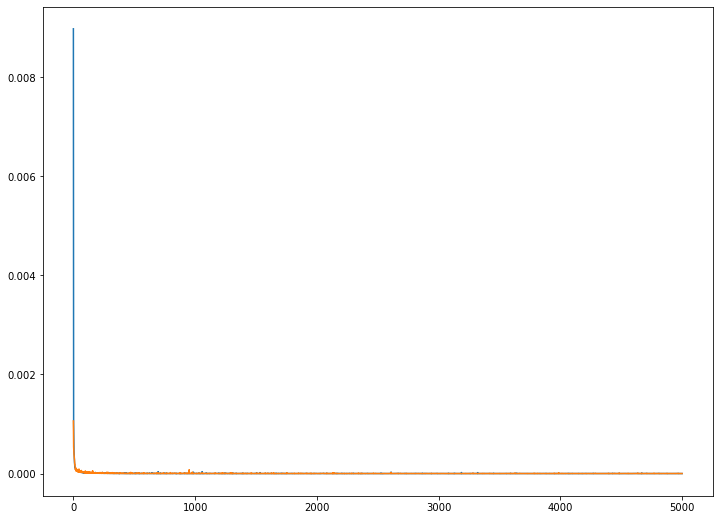

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

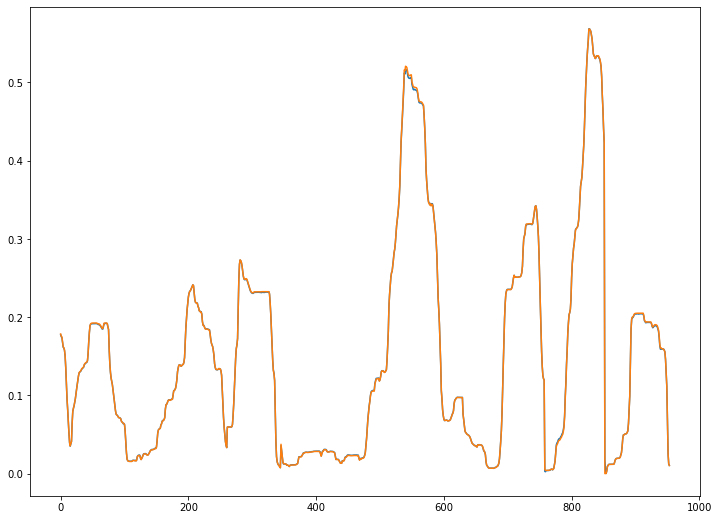

In [15]:
plt.figure(figsize=(12, 9))
plt.plot(pred,label='prediction')
plt.plot(test_y,label='real')
plt.show()